**Programmabibliotheken in notebook laden...**

In [1]:
import dependencies
import jupyter_addons as ja

In [2]:
ja.set_css()

In [3]:
import pandas as pd
from lib import Analyzer
import quantities as qty
from pypeflow.core.flow_coefficient import FlowCoefficient
from pypeflow.core.resistance_coefficient import ResistanceCoefficient
from pypeflow.core.fluids import Water
from pypeflow.core.pipe_schedules import PipeSchedule40
from pypeflow.utils.pump_curve import calculate_pump_curve, PumpCurve
from pypeflow.utils.system_curve import calculate_system_curves, draw_curves

# Analyse drinkwaterleidingnetwerk appartementsgebouw

<div class="alert alert-block alert-info">
<b>Om het principeschema van het leidingnetwerk te bekijken, klik op deze <a href="./static/gebouw.pdf">link</a></b>.
</div>

<mark>Het doel van deze notebook bestaat erin om m.b.v. de methode van Hardy Cross het werkpunt van de drukverhogingspomp te bepalen **onder condities die overeenstemmen met een "normaal" piekwaterverbruik bepaald op basis van de norm DIN 1988-300**.</mark>

**Maateenheden instellen**

In [4]:
Analyzer.set_units({
    'length': 'm',
    'diameter': 'mm',
    'flow_rate': 'L/s',
    'pressure': 'bar',
    'velocity': 'm/s'
})

**Netwerkmodel initialiseren**

In [5]:
Analyzer.create_network(
    start_node_id='n1',
    end_node_id='n0',
    fluid='water',
    fluid_temperature=10.0,
    pipe_schedule='pipe_schedule_40'
)

**Netwerkmodel configureren**<br>
De configuratie van het netwerk gebeurt via een afzonderlijk [spreadsheetbestand](./input_files/hardy_gebouw.csv), opgeslagen in *csv*-opmaak. Het netwerkmodel omvat de drukverhogingspomp NOCCHI VLR 4-60 A M 50 (pompcoëfficiënten: zie rij 1, in leidingsectie *s01*) en de opvoerdruk vanuit het openbare net bedraagt **2 bar** (zie rij 4, sectie *s10*). <mark>**De sanitaire installaties in de appartementen op elke verdieping zijn gereduceerd tot één "equivalente" kraan met een weerstandscoëfficiënt van 23064, hetgeen overeenstemt met een openingsstand van de equivalente kranen die resulteert in een "normaal" piekdebiet op gebouwniveau van ca. 1,7 L/s (zie bepaling in de rekenota's bij het voorverslag).**</mark>

In [6]:
Analyzer.configure_network('.\\input_files\\hardy_gebouw.csv')

**Netwerk oplossen: volumedebieten en stromingsverliezen in de takken berekenen**

In [7]:
Analyzer.solve(error=1.0e-3, i_max=5000)

**Resultaat ophalen**

In [8]:
df = Analyzer.get_network()

**Resultaat filteren: "verdiepingstakken" selecteren**<br>
In de onderstaande tabel kan men aflezen welk volumedebiet door de verdiepingstakken van het leidingnetwerk stroomt (kolom `flow_rate`).

In [9]:
dff = df.iloc[[r for r in range(1,32,4)], :]
ja.display_table(dff)

,loop_id,section_id,start_node_id,end_node_id,length [m],diameter [mm],zeta,flow_rate [L/s],velocity [m/s],pressure_drop [bar]
1,l1,s22*,n2,n2*,0.1,40.9,23064.0,0.262,0.199,4.575
5,l2,s33*,n3,n3*,0.1,40.9,23064.0,0.254,0.193,4.298
9,l3,s44*,n4,n4*,0.1,40.9,23064.0,0.245,0.187,4.024
13,l4,s55*,n5,n5*,0.1,40.9,23064.0,0.237,0.180,3.753
17,l5,s66*,n6,n6*,0.1,40.9,23064.0,0.228,0.174,3.485
21,l6,s77*,n7,n7*,0.1,40.9,23064.0,0.219,0.167,3.217
25,l7,s88*,n8,n8*,0.1,40.9,23064.0,0.210,0.160,2.951
29,l8,s99*,n9,n9*,0.1,40.9,23064.0,0.201,0.153,2.686


**Stroompaden in het netwerk analyseren**

In [10]:
dfp = Analyzer.get_paths()
ja.display_table(dfp)

,path,"dp,vel [bar]","dp,elev [bar]","dp,loss (net) [bar]","dp,stat [bar]"
0,s12|s22*|s2*0,-0.01,0.432,1.568,-1.99
1,s12|s23|s33*|s3*2*|s2*0,-0.01,0.697,1.303,-1.99
2,s12|s23|s34|s44*|s4*3*|s3*2*|s2*0,-0.01,0.962,1.038,-1.99
3,s12|s23|s34|s45|s55*|s5*4*|s4*3*|s3*2*|s2*0,-0.01,1.227,0.773,-1.99
4,s12|s23|s34|s45|s56|s66*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,-0.01,1.492,0.508,-1.99
5,s12|s23|s34|s45|s56|s67|s77*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,-0.01,1.757,0.243,-1.99
6,s12|s23|s34|s45|s56|s67|s78|s88*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,-0.01,2.022,-0.022,-1.99
7,s12|s23|s34|s45|s56|s67|s78|s89|s99*|s9*8*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,-0.01,2.287,-0.287,-1.99


>**Nota omtrent de energievergelijking toegepast op een stroompad**<br>
>De energievergelijking toegepast op een stroompad tussen het start- (subscript 1) en eindknooppunt (subscript 2) van een netwerk kan worden geschreven als:
$$
\left( {{p_1} + \rho \frac{{v_1^2}}{2} + \rho g{z_1}} \right) + \Delta {p_P} - \Delta {p_L} = \left( {{p_2} + \rho \frac{{v_2^2}}{2} + \rho g{z_2}} \right)
$$
>met:
>- ${p_1}$ = statische druk in het startknooppunt
>- ${\rho \frac{{v_1^2}}{2}}$ = kinetische druk (snelheidsdruk) in het startknooppunt
>- ${\rho g{z_1}}$ = gravitatiedruk in het startknooppunt 
>- ${\Delta {p_P}}$ = mechanische energie, uitgedrukt in eenheid van druk, door een pomp toegevoerd aan het water tussen start- en eindknooppunt van het stroompad
>- ${\Delta {p_L}}$ = mechanisch energieverlies, uitgedrukt in eenheid van druk, van het water tussen tussen start- en eindknooppunt van het stroompad te wijten aan wrijving en fittingen
>
> Deze vergelijking kan men ook uitwerken tot:
$$
\left( {{p_2} - {p_1}} \right) + \frac{\rho }{2}\left( {v_2^2 - v_1^2} \right) + \rho g\left( {{z_2} - {z_1}} \right) + \left( {\Delta {p_L} - \Delta {p_P}} \right) = 0
$$
>met:
>- ${{p_2} - {p_1}}$ = statisch drukverschil van eindknooppunt t.o.v. startknooppunt (= `dp,stat`)
>- ${\frac{\rho }{2}\left( {v_2^2 - v_1^2} \right)}$ = snelheidsdrukverschil van eindknooppunt t.o.v. startknooppunt (= `dp,vel`)
>- ${\rho g\left( {{z_2} - {z_1}} \right)}$ = hoogtedrukverschil van eindknooppunt t.o.v. startknooppunt (= `dp, elev`)
>- ${\left( {\Delta {p_L} - \Delta {p_P}} \right)}$ = netto mechanisch energieverlies tussen tussen start- en eindknooppunt (= `dp,loss (net)`)
>
>Het dient hier opgemerkt dat in het netto energieverlies de toegevoerde pompenergie is vervat. Een negatieve waarde duidt op winst i.p.v. verlies.
>Men kan nagaan in de tabel hierboven dat de som van de kolomwaarden voor elk stroompad nul is.

## Werkpunt van de pomp bepalen

**Pompcurve-coëfficiënten van de pomp NOCCHI VLR 4-60 A M 50 bepalen (bij 2900 rpm @ 50 Hz)**

In [11]:
pump_curve = PumpCurve(desired_units={'flow_rate': 'L/s', 'pressure': 'bar'})

# enter the measured points from the curve in the data sheet
pump_curve.add_measuring_points(
    points=[(0.0, 60.0), (2.4, 52.0), (4.2, 48.0), (6.0, 36.0)],
    units={'flow_rate': 'm^3/h', 'pressure': 'm'}
)

# get the pump coefficients, set the units for flow rate and pressure in which the 
# coefficients need to be expressed
a = pump_curve.get_coefficients()

ja.display_item(f'Pompcurve-coefficienten = <b>{a}</b> gerefereerd aan de eenheden <b>L/s</b> en <b>bar</b>')

**Opvoerdruk van de pomp bepalen**<br>
Om de opvoerdruk van de pomp te kennen onder de opgegeven bedrijfscondities, moet men eerst het volumedebiet ophalen dat door de "pompsectie" stroomt (zie spreadsheetbestand, rij 1, leidingsectie *s12*). Dat is het volumedebiet dat in het leidingnetwerk binnenstroomt.

In [12]:
V_pump = Analyzer.network.flow_rate('L/s')
ja.display_item(f'Volumedebiet door de drukverhogingspomp (in sectie <em>s12</em>) = <b>{V_pump:.3f}</b> L/s')

Met de gekende pompcurve-coëfficiënten en het volumedebiet kan nu de opvoerdruk van de pomp berekend worden:

In [13]:
dp_pump = a[0] + a[1] * V_pump + a[2] * V_pump ** 2
ja.display_item(f'Opvoerdruk van de pomp bij volumdebiet {V_pump:.3f} L/s = <b>{dp_pump:.3f}</b> bar')

<mark>Bij deze is het werkpunt van de pomp volledig bepaald voor de **opgegeven bedrijfscondities**.</mark>

**Pomp- en stroompadcurven tekenen**

In [14]:
sys_curves = calculate_system_curves(
    flow_paths=Analyzer.network.paths,
    V_wp=Analyzer.network.flow_rate,
    dp_wp=qty.Pressure(dp_pump, 'bar'),
    unit_flow_rate='L/s',
    unit_pressure='bar',
    V_end=qty.VolumeFlowRate(3.0, 'L/s')
)

In [15]:
pump_curve = calculate_pump_curve(
    coeff_values=a, 
    coeff_units={'flow_rate': 'L/s', 'pressure': 'bar'},
    unit_flow_rate='L/s',
    unit_pressure='bar',
    V_end=qty.VolumeFlowRate(3.0, 'L/s')
)

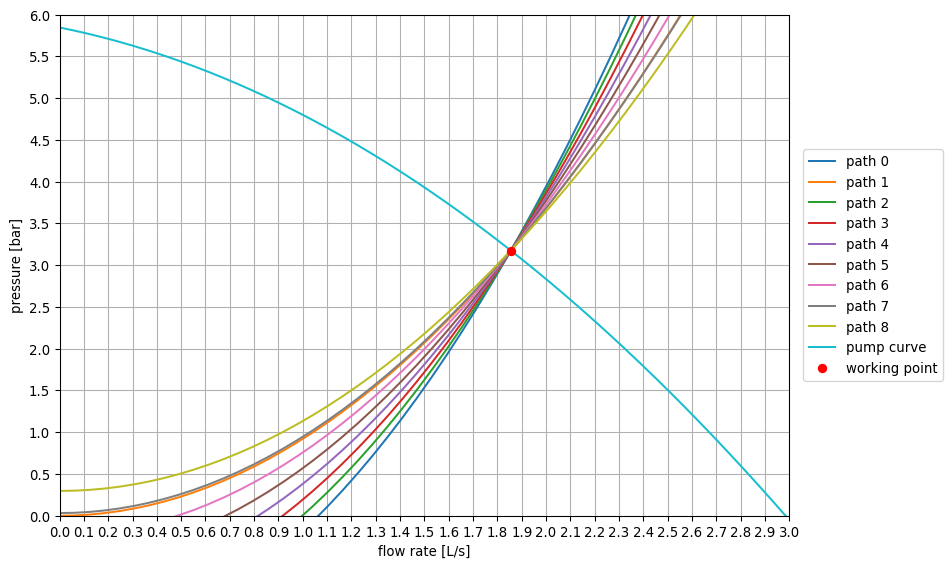

In [16]:
graph = draw_curves(
    sys_curves=sys_curves,
    pump_curves=[pump_curve],
    units=('L/s', 'bar'),
    fig_size=(10, 6),
    dpi=96,
    V_max=3.0,
    V_step=0.1,
    p_max=6.0,
    p_step=0.5,
    working_point=(V_pump, dp_pump)
)
graph.show()